In [1]:
import sys
sys.path.append("../src")
from dataio import *
from metric import *
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd

In [2]:
def make_df(idx,daily=False):
    rivout = load_dam_rivout(idx,daily=daily)
    
    discharge = load_dam_discharge(idx)
    discharge = pd.concat(load_dam_discharge(idx))
    #processing missing data
    discharge[discharge<0] = np.nan
    discharge.fillna(method='ffill',inplace=True,limit=3)
    discharge.dropna(inplace=True)
    #match timezone
    discharge.index -= datetime.timedelta(hours=9)
    if daily:
        discharge.index = discharge.index.date
        discharge.index.name = 'date'
        discharge = discharge.groupby(level=['date']).mean()
        discharge.index = pd.to_datetime(discharge.index)
    
    df = pd.concat([rivout,discharge],axis=1)
    df = df.dropna(how='any')
    df.columns=['x','y']
    return df 

In [3]:
df = pd.read_pickle('data_details.pkl')
idxs = df[~(df['lack of data']) & (df['network exist']) & ~(df['other dams'])].index

## 1. Daily Evaluation

### 1.1 Total error

In [4]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [95]:
dam_id,ms,ns,kg = [],[],[],[]
num = []
results = {}

for idx in tqdm(idxs):
    df = make_df(idx,daily=True)
    x = df.values[:,0].reshape(-1, 1)
    y = df.values[:,1].reshape(-1, 1)
    
    msk_tr = df.index<datetime.datetime(2018,9,1)
    tr_idx = np.where(msk_tr)[0]
    te_idx = np.where(~msk_tr)[0]

    train_x, test_x = x[tr_idx], x[te_idx]
    train_y, test_y = y[tr_idx], y[te_idx]
    
    lr = LinearRegression()
    lr.fit(train_x,train_y)
    predict = lr.predict(test_x)
    
    results[idx]=[mse(predict,test_y),
                  nse(predict,test_y),
                  kge(predict,test_y),
                  test_y.mean()-predict.mean()]

results = pd.DataFrame(results,index=['mse','ns','kge','bias']).T

100%|███████████████████████████████████████████| 91/91 [00:41<00:00,  2.18it/s]


mse     562.960839
ns        0.513255
kge       0.605075
bias     -1.107193
dtype: float64


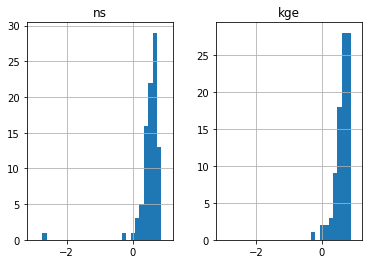

In [66]:
results[['ns','kge']].hist(range=[-3,1],bins=30)
print(results.mean())

### 1.2 Seasonal effects

In [43]:
monthly_ns = {}
monthly_kge = {}

for idx in tqdm(idxs):
    df = make_df(idx)
    x = df.values[:,0].reshape(-1, 1)
    y = df.values[:,1].reshape(-1, 1)
    
    msk_tr = df.index<datetime.datetime(2018,9,1)
    tr_idx = np.where(msk_tr)[0]
    te_idx = np.where(~msk_tr)[0]
    
    test_time = df.index[~msk_tr]

    train_x, test_x = x[tr_idx], x[te_idx]
    train_y, test_y = y[tr_idx], y[te_idx]
    
    lr = LinearRegression()
    lr.fit(train_x,train_y)
    predict = lr.predict(test_x)
    
    temp_ns,temp_kge = [],[]
    for month in range(1,13):
#         temp_ns.append(nse(predict[test_time.month==month],test_y[test_time.month==month]))
        temp_kge.append(kge(predict[test_time.month==month],test_y[test_time.month==month]))
    
    monthly_ns[idx] = temp_ns
    monthly_kge[idx] = temp_kge
    
monthly_ns = pd.DataFrame(monthly_ns).T
monthly_kge = pd.DataFrame(monthly_kge).T

  2%|▉                                           | 2/91 [00:01<00:46,  1.92it/s]/home/yoshimi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yoshimi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
  4%|█▉                                          | 4/91 [00:02<00:44,  1.96it/s]/home/yoshimi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yoshimi/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|███████████████████████████████████████████| 91/91 [00:43<00:00,  2.10it/s]


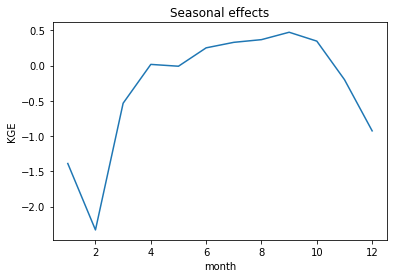

In [45]:
plt.plot(range(1,13),monthly_kge.mean(axis=0))
plt.title('Seasonal effects')
plt.xlabel("month")
plt.ylabel("KGE")
plt.show()

### 1.3 latitude effects

(0.0, 1.0)

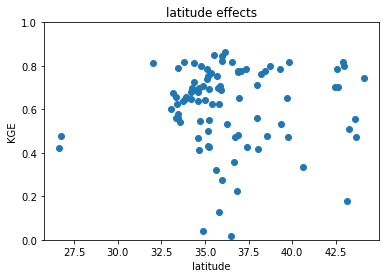

In [77]:
details = load_dam_details()
lt = [x[0] for x in details.loc[idxs,'coordinates'].values]

plt.scatter(lt,results['kge'])
plt.xlabel('latitude')
plt.ylabel('KGE')
plt.title('latitude effects')
plt.ylim(0,1)

## 2. Hourly Evaluation

In [5]:
dam_id,ms,ns,kg = [],[],[],[]
num = []
results = {}

for idx in tqdm(idxs):
    df = make_df(idx,daily=False)
    x = df.values[:,0].reshape(-1, 1)
    y = df.values[:,1].reshape(-1, 1)
    
    results[idx]=[mse(x,y),
                  nse(x,y),
                  kge(x,y),
                  y.mean()-x.mean()]

results = pd.DataFrame(results,index=['mse','ns','kge','bias']).T

100%|███████████████████████████████████████████| 91/91 [00:38<00:00,  2.37it/s]


mse     2245.808097
ns        -2.418089
kge       -0.425351
bias       7.201099
dtype: float64


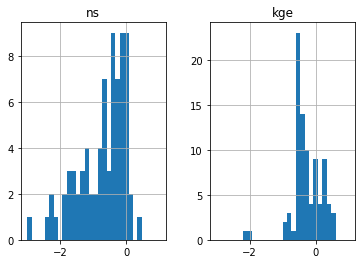

In [6]:
results[['ns','kge']].hist(range=[-3,1],bins=30)
print(results.mean())